<a href="https://colab.research.google.com/github/benny-liang0623/maboo/blob/main/Brand/BCE/xlnet_multi_class_chinese_brand_single_label_bcel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.06.09 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-label and single-label classification.

## **Contents**
1. Dataset
   *   Cleaned dataset
   *   Convert 'brand' to dummy variables
   *   Get small sample of train and test to try (optional)
<br/>
2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. Train, Valid Split<br/>
4. Create Dataloaders (torch tensors)<br/>
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>
7. Evaluate Validation Set<br/>
   (1) Predicting<br/>
   (2) Evaluation<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [ ]:
!pip install transformers
# !pip install sentencepiece # for English

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import math
import torch
# from torch.nn import CrossEntropyLoss # for single-label
from torch.nn import BCEWithLogitsLoss # for multi-label
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## **1. Dataset**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cleaned dataset

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/train_brand.csv')
test = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/test/test_brand7.csv')

In [ ]:
train_data = {'id': range(1, len(train_raw) + 1),
              'name': train_raw['name'],
              'brand': train_raw['brand']}
train_clean = pd.DataFrame(train_data)
train_clean.head()

,id,name,brand
0,1,元山熱水瓶ys5401a,元山牌
1,2,ys5504aps熱水瓶,元山牌
2,3,展元山8l多功能電烤箱型號ys5081ot,元山牌
3,4,元山牌迴風式烘碗機,元山牌
4,5,元山熱水瓶ys5401a,元山牌


In [ ]:
# number of classes 2022.06.09
class_num = train_clean['brand'].nunique() 
class_num

3452

In [ ]:
test

,id,name,brand
0,90001,光泉鮮豆漿200ml,NaN
1,90002,現貨kirklandsignature科克蘭三層抽取衛生紙120張x12入半大包,NaN
2,90003,toshiba東芝20公升微電腦料理微波爐mmem20pwh現貨廠商直送,NaN
3,90004,cookpower鍋寶12l數位觸控式健康氣炸烤箱白af1220wgr,NaN
4,90005,台鹽膠原草本固根護理牙膏120g支,NaN
...,...,...,...
7154,97155,石澤研究所毛穴撫子角質對策泡洗顏100g,NaN
7155,97156,金牌台灣啤酒330ml6入,NaN
7156,97157,日清中杯麵醬油,NaN
7157,97158,杜蕾斯活力裝衛生套個盒,NaN


### Convert 'brand' to dummy variables

In [ ]:
train_valid = train_clean[['id', 'name', 'brand']]
brands = pd.get_dummies(train_clean['brand'])
train_valid = pd.concat([train_valid, brands], axis=1)
train_valid

,id,name,brand,080,1028,11益生菌,13章,16 brand,17PIN,1ST CHOICE,...,齊葉雅ziaja,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬
0,1,元山熱水瓶ys5401a,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,ys5504aps熱水瓶,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,展元山8l多功能電烤箱型號ys5081ot,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,元山牌迴風式烘碗機,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,元山熱水瓶ys5401a,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104279,104280,聖沛黎洛礦泉水,S.Pellegrino,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104280,104281,聖沛黎洛礦泉水,S.Pellegrino,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104281,104282,聖沛黎洛礦泉水,S.Pellegrino,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104282,104283,聖沛黎洛礦泉水,S.Pellegrino,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
# train_valid = train_valid.sample(n=1000)
# test = test.sample(n=100)

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

In [ ]:
# Texts for classification
train_text_list = train_valid['name'].values
test_text_list = test['name'].values

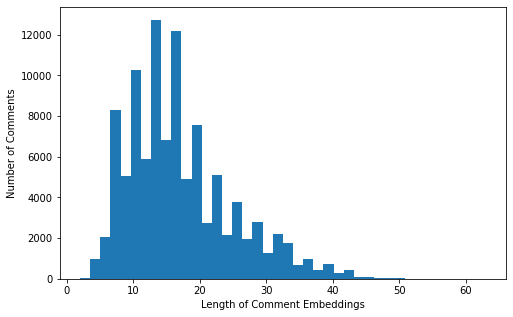

In [ ]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

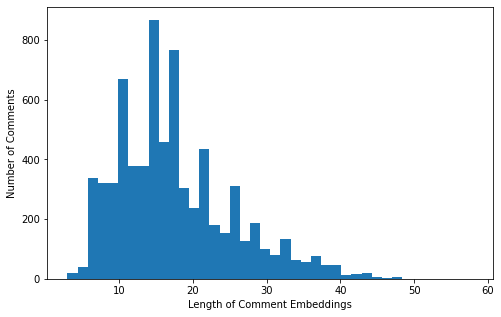

In [ ]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [ ]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
train_input_ids

array([[ 6474,    83,  1119, ...,     0,     0,     0],
       [   19,  8448, 13157, ...,     0,     0,     0],
       [   19,  1192,   218, ...,     0,     0,     0],
       ...,
       [ 8634,  8515,  2331, ...,     0,     0,     0],
       [ 8634,  8515,  2331, ...,     0,     0,     0],
       [ 8634,  8515,  2331, ...,     0,     0,     0]])

In [ ]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
test_input_ids

array([[   19,   182,  1537, ...,     0,     0,     0],
       [   19,  1556,  4217, ...,     0,     0,     0],
       [   19,  3055, 14165, ...,     0,     0,     0],
       ...,
       [   19,    29,   296, ...,     0,     0,     0],
       [ 8690,  5707,   102, ...,     0,     0,     0],
       [ 4522,    97,   106, ...,     0,     0,     0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [ ]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [ ]:
# train
train_valid["features"] = train_input_ids.tolist()
train_valid["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
train_valid.head()

,id,name,brand,080,1028,11益生菌,13章,16 brand,17PIN,1ST CHOICE,...,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬,features,masks
0,1,元山熱水瓶ys5401a,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[6474, 83, 1119, 111, 4363, 8448, 2288, 3343, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,ys5504aps熱水瓶,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 8448, 13157, 57, 5672, 150, 1119, 111, 43...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,3,展元山8l多功能電烤箱型號ys5081ot,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 1192, 218, 83, 69, 1408, 18794, 804, 8797...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,元山牌迴風式烘碗機,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[6474, 83, 977, 6410, 611, 208, 19401, 9563, 4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,5,元山熱水瓶ys5401a,元山牌,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[6474, 83, 1119, 111, 4363, 8448, 2288, 3343, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,id,name,brand,features,masks
0,90001,光泉鮮豆漿200ml,NaN,"[19, 182, 1537, 5925, 2782, 10616, 1321, 746, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,90002,現貨kirklandsignature科克蘭三層抽取衛生紙120張x12入半大包,NaN,"[19, 1556, 4217, 7984, 13665, 6231, 16000, 217...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,90003,toshiba東芝20公升微電腦料理微波爐mmem20pwh現貨廠商直送,NaN,"[19, 3055, 14165, 5297, 234, 4032, 162, 228, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,90004,cookpower鍋寶12l數位觸控式健康氣炸烤箱白af1220wgr,NaN,"[9169, 10771, 5335, 16219, 14347, 899, 90, 140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,90005,台鹽膠原草本固根護理牙膏120g支,NaN,"[19, 200, 3077, 6171, 210, 668, 152, 2012, 648...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split (2022.06.09 update)**


---



In [ ]:
# train valid split (2022.06.09)
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)

In [ ]:
# find the random state that training and validating set has all the classes
# best_state = 42
# for i in range(1,100):
#   if valid['brand'].nunique() != class_num:
#     train, valid = train_test_split(train_valid, test_size=0.2, random_state=i)
#     if valid['brand'].nunique() == class_num:
#       best_state = i
    
# print(best_state)

In [ ]:
print(train['brand'].nunique())
print(valid['brand'].nunique())

3452
3443


In [ ]:
# optional
train.to_csv("/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品牌/xlnet_brand_single_bcel_trainset.csv")
valid.to_csv("/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品牌/xlnet_brand_single_bcel_validset.csv")

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# brands column names
label_cols = brands.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [ ]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased') # for English
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base") # for Chinese
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      # loss_fct = CrossEntropyLoss() # for single-label
      loss_fct = BCEWithLogitsLoss() # for multi-label
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Need GPU
# Modify output path

num_epochs=5

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品牌/xlnet_brand_single_bcel.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.000190579839340592
Valid loss: 8.263377440920876e-05


Epoch:  20%|██        | 1/5 [14:39<58:38, 879.73s/it]

Saving model at epoch 0 with validation loss of 8.263377440920876e-05


Train loss: 8.269180190903889e-05


Epoch:  40%|████      | 2/5 [29:22<44:04, 881.58s/it]

Valid loss: 8.296147856695066e-05


Train loss: 8.268006321687168e-05
Valid loss: 8.24791220710994e-05


Epoch:  60%|██████    | 3/5 [44:08<29:27, 883.59s/it]

Saving model at epoch 2 with validation loss of 8.24791220710994e-05


Train loss: 8.120367845961172e-05
Valid loss: 7.892540115419236e-05


Epoch:  80%|████████  | 4/5 [58:57<14:45, 885.80s/it]

Saving model at epoch 3 with validation loss of 7.892540115419236e-05


Train loss: 7.245080647638798e-05
Valid loss: 5.731864384653119e-05


Epoch: 100%|██████████| 5/5 [1:13:49<00:00, 885.86s/it]

Saving model at epoch 4 with validation loss of 5.731864384653119e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

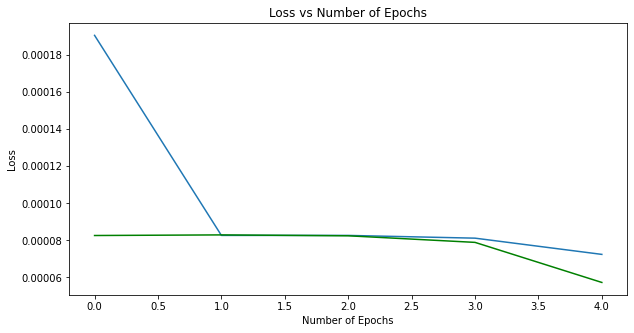

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品牌/xlnet_brand_single_bcel.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
num_epochs=5
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.227073491652825e-05
Valid loss: 2.170217119128692e-05


Epoch:  20%|██        | 1/5 [14:51<59:27, 891.91s/it]

Saving model at epoch 4 with validation loss of 2.170217119128692e-05


Train loss: 1.8324605212016068e-05
Valid loss: 9.536097236102453e-06


Epoch:  40%|████      | 2/5 [29:42<44:33, 891.17s/it]

Saving model at epoch 5 with validation loss of 9.536097236102453e-06


Train loss: 9.126690733267604e-06
Valid loss: 5.328412188329614e-06


Epoch:  60%|██████    | 3/5 [44:32<29:41, 890.75s/it]

Saving model at epoch 6 with validation loss of 5.328412188329614e-06


Train loss: 5.470415764715571e-06
Valid loss: 3.838870019100868e-06


Epoch:  80%|████████  | 4/5 [59:22<14:50, 890.43s/it]

Saving model at epoch 7 with validation loss of 3.838870019100868e-06


Train loss: 3.701129548848487e-06
Valid loss: 2.8122408610883864e-06


Epoch: 100%|██████████| 5/5 [1:14:12<00:00, 890.53s/it]

Saving model at epoch 8 with validation loss of 2.8122408610883864e-06




Text(0.5, 1.0, 'Loss vs Number of Epochs')

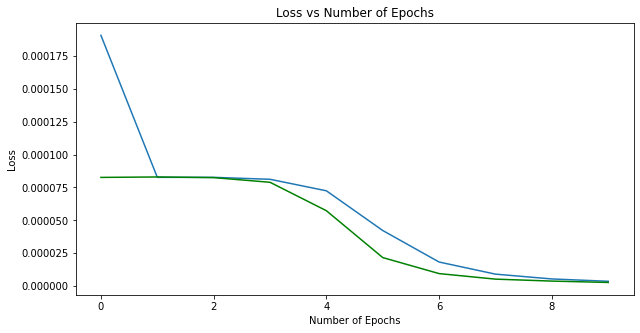

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[7.74657201e-06, 4.43154249e-06, 4.64427649e-05, ...,
        5.85070484e-06, 1.29577656e-05, 7.99569025e-05],
       [1.07737324e-05, 2.22906550e-07, 4.70365085e-05, ...,
        4.34560980e-06, 7.15808164e-06, 9.00244359e-08],
       [4.74767558e-06, 1.64949358e-06, 9.07560934e-06, ...,
        3.63111349e-06, 7.33660499e-06, 2.47413459e-06],
       ...,
       [5.12762199e-06, 3.23996101e-05, 3.46461784e-05, ...,
        3.75885270e-06, 2.47662979e-06, 3.65862576e-07],
       [1.11959089e-05, 1.93709025e-06, 8.03888156e-07, ...,
        3.68046642e-07, 6.64286290e-06, 1.67708868e-06],
       [7.16747963e-05, 2.08246956e-06, 1.48711285e-06, ...,
        9.43160376e-06, 8.12601172e-07, 2.25807307e-05]])

In [ ]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,brand,features,masks,080,1028,11益生菌,13章,16 brand,...,齊葉雅ziaja,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬
0,90001,光泉鮮豆漿200ml,NaN,"[19, 182, 1537, 5925, 2782, 10616, 1321, 746, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000008,4.431542e-06,0.000046,0.000017,0.000004,...,0.000003,0.000010,0.000006,0.000003,0.000007,0.000017,0.001606,5.850705e-06,0.000013,7.995690e-05
1,90002,現貨kirklandsignature科克蘭三層抽取衛生紙120張x12入半大包,NaN,"[19, 1556, 4217, 7984, 13665, 6231, 16000, 217...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000011,2.229066e-07,0.000047,0.000004,0.000010,...,0.000005,0.000097,0.000006,0.000001,0.000007,0.000074,0.000002,4.345610e-06,0.000007,9.002444e-08
2,90003,toshiba東芝20公升微電腦料理微波爐mmem20pwh現貨廠商直送,NaN,"[19, 3055, 14165, 5297, 234, 4032, 162, 228, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000005,1.649494e-06,0.000009,0.000015,0.000015,...,0.000009,0.000063,0.000009,0.000001,0.000029,0.000014,0.000003,3.631113e-06,0.000007,2.474135e-06
3,90004,cookpower鍋寶12l數位觸控式健康氣炸烤箱白af1220wgr,NaN,"[9169, 10771, 5335, 16219, 14347, 899, 90, 140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000003,7.027893e-05,0.000007,0.000871,0.000014,...,0.000041,0.000020,0.000002,0.000024,0.000006,0.000023,0.000036,1.064055e-05,0.000008,3.871235e-06
4,90005,台鹽膠原草本固根護理牙膏120g支,NaN,"[19, 200, 3077, 6171, 210, 668, 152, 2012, 648...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000074,2.184679e-06,0.000122,0.000009,0.000003,...,0.000001,0.000016,0.000020,0.000056,0.000450,0.000001,0.000002,4.005072e-07,0.000007,5.766033e-06


### (2) For single-label classification

In [ ]:
# Get the maximum probability for each row
test['max_prob'] = test.iloc[:,5:].max(axis = 1).round(5)
test['brand_predict'] = test.iloc[:,5:-1].idxmax(axis = 1)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


,id,name,brand,features,masks,080,1028,11益生菌,13章,16 brand,...,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬,max_prob,brand_predict
0,90001,光泉鮮豆漿200ml,NaN,"[19, 182, 1537, 5925, 2782, 10616, 1321, 746, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000008,4.431542e-06,4.644276e-05,1.655845e-05,0.000004,...,5.748869e-06,0.000003,6.902887e-06,0.000017,0.001606,5.850705e-06,1.295777e-05,7.995690e-05,0.99752,光泉豆漿
1,90002,現貨kirklandsignature科克蘭三層抽取衛生紙120張x12入半大包,NaN,"[19, 1556, 4217, 7984, 13665, 6231, 16000, 217...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000011,2.229066e-07,4.703651e-05,4.236164e-06,0.000010,...,6.492084e-06,0.000001,6.590804e-06,0.000074,0.000002,4.345610e-06,7.158082e-06,9.002444e-08,0.04390,科克蘭 kirklandsignature
2,90003,toshiba東芝20公升微電腦料理微波爐mmem20pwh現貨廠商直送,NaN,"[19, 3055, 14165, 5297, 234, 4032, 162, 228, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000005,1.649494e-06,9.075609e-06,1.509882e-05,0.000015,...,8.767423e-06,0.000001,2.890780e-05,0.000014,0.000003,3.631113e-06,7.336605e-06,2.474135e-06,0.99819,東芝toshiba
3,90004,cookpower鍋寶12l數位觸控式健康氣炸烤箱白af1220wgr,NaN,"[9169, 10771, 5335, 16219, 14347, 899, 90, 140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000003,7.027893e-05,6.959349e-06,8.710290e-04,0.000014,...,2.478038e-06,0.000024,6.325466e-06,0.000023,0.000036,1.064055e-05,7.588341e-06,3.871235e-06,0.99633,鍋寶cookpower
4,90005,台鹽膠原草本固根護理牙膏120g支,NaN,"[19, 200, 3077, 6171, 210, 668, 152, 2012, 648...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000074,2.184679e-06,1.219772e-04,8.573587e-06,0.000003,...,1.951222e-05,0.000056,4.495864e-04,0.000001,0.000002,4.005072e-07,6.715394e-06,5.766033e-06,0.97435,台鹽生技
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,97155,石澤研究所毛穴撫子角質對策泡洗顏100g,NaN,"[9862, 1900, 2099, 808, 6699, 7561, 80, 498, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000153,5.537369e-05,2.390485e-05,1.170877e-05,0.000005,...,4.364384e-05,0.000007,6.030941e-02,0.000008,0.000007,3.499033e-05,6.489374e-05,5.179937e-06,0.06031,齒磨撫子
7155,97156,金牌台灣啤酒330ml6入,NaN,"[19, 4292, 292, 9234, 13072, 746, 1408, 62, 21...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000002,2.744314e-06,1.045907e-05,1.284078e-05,0.000003,...,2.386743e-06,0.000003,2.986658e-06,0.000004,0.000666,5.411030e-06,5.389788e-07,1.045639e-04,0.99694,台灣啤酒
7156,97157,日清中杯麵醬油,NaN,"[19, 29, 296, 28, 2252, 6702, 11873, 940, 4, 3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000005,3.239961e-05,3.464618e-05,3.210036e-06,0.000001,...,1.155296e-05,0.000002,3.202126e-06,0.000100,0.000002,3.758853e-06,2.476630e-06,3.658626e-07,0.98917,日清
7157,97158,杜蕾斯活力裝衛生套個盒,NaN,"[8690, 5707, 102, 16608, 1748, 6233, 1598, 315...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000011,1.937090e-06,8.038882e-07,1.573434e-07,0.000022,...,3.733041e-07,0.000007,1.744676e-06,0.000001,0.000016,3.680466e-07,6.642863e-06,1.677089e-06,0.00614,大衛杜夫


### (3) Save the predicting results

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/output/final/xlnet_brand_single_predict_bcel_7.csv")
test.to_csv(pred_save_path, index=False)

## **7. Evaluate Validation Set**


---



In [ ]:
valid_data = valid[["id", "name", "brand", "features", "masks"]]
valid_data

,id,name,brand,features,masks
63085,63086,fs森林小舖香薰專用51檜木精油5ml,FS森林小舖,"[7188, 150, 2478, 96, 14062, 874, 15531, 8389,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
97107,97108,hallmark童話大寶洗沐組童話洗髮沐浴,Hallmark,"[19, 1141, 5331, 11837, 1019, 22372, 44, 899, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
14042,14043,lg樂金a9地毯吸頭agb74272403a9吸塵器適用,樂金lg,"[15344, 1232, 774, 139, 971, 73, 78, 17326, 32...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3221,3222,sowasowa純淨香氛洗髮精,SOWA SOWA,"[19, 10073, 9558, 10073, 9558, 3561, 5876, 874...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
33041,33042,東泉辣椒醬420g,東泉,"[11911, 1537, 19297, 11873, 57, 162, 1232, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...
36005,36006,vitakraft貓快餐貓肉條貓零食3入包,vita,"[19, 4929, 3245, 1019, 22230, 3378, 1143, 3798...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
52051,52052,nokia546g64g639吋四鏡頭智慧手機夢境紫,NOKIA,"[19, 4615, 1019, 2053, 56, 1736, 1232, 1746, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
27901,27902,加倍潔洗衣液體小蘇打淨白1600gm,加倍潔,"[19, 178, 1589, 5489, 21816, 16474, 96, 1041, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
61249,61250,舒芙蕾英文巧拼地墊26片1入,APG,"[19, 2763, 7302, 5707, 1307, 5137, 5747, 78, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


### (1) Predicting

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, valid_data, num_labels, device="cuda", batch_size=32)
for i in label_cols:
  valid_data[i] = pred_probs[:,label_cols.index(i)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [ ]:
# Get the maximum probability for each row
valid_data['brand_predict'] = valid_data.iloc[:,5:].idxmax(axis = 1)
valid_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,brand,features,masks,080,1028,11益生菌,13章,16 brand,...,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬,brand_predict
63085,63086,fs森林小舖香薰專用51檜木精油5ml,FS森林小舖,"[7188, 150, 2478, 96, 14062, 874, 15531, 8389,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000003,5.353652e-07,1.210135e-05,1.024549e-03,7.650599e-07,...,2.770123e-05,4.586342e-06,1.531670e-06,0.000050,0.000013,8.925983e-05,0.000005,8.245819e-07,1.281137e-06,FS森林小舖
97107,97108,hallmark童話大寶洗沐組童話洗髮沐浴,Hallmark,"[19, 1141, 5331, 11837, 1019, 22372, 44, 899, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000044,6.290143e-06,1.287979e-06,1.177141e-05,2.392643e-06,...,4.032144e-06,1.027986e-05,9.364038e-05,0.000001,0.000046,1.421343e-06,0.000019,3.420273e-05,1.275079e-06,Hallmark
14042,14043,lg樂金a9地毯吸頭agb74272403a9吸塵器適用,樂金lg,"[15344, 1232, 774, 139, 971, 73, 78, 17326, 32...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000009,3.217889e-06,1.550286e-05,1.609760e-05,6.179139e-07,...,7.838789e-07,1.930082e-07,1.314177e-06,0.000008,0.000004,1.020879e-05,0.000022,9.966399e-07,9.278522e-06,樂金lg
3221,3222,sowasowa純淨香氛洗髮精,SOWA SOWA,"[19, 10073, 9558, 10073, 9558, 3561, 5876, 874...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000007,9.691489e-07,1.095896e-05,1.070691e-05,5.728960e-05,...,5.502161e-06,2.636443e-05,8.697628e-06,0.000006,0.000009,3.936874e-05,0.000002,2.113538e-06,3.466529e-06,SOWA SOWA
33041,33042,東泉辣椒醬420g,東泉,"[11911, 1537, 19297, 11873, 57, 162, 1232, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000007,5.071835e-07,3.843869e-05,1.113281e-06,3.666950e-06,...,3.651633e-06,7.392728e-06,1.212399e-06,0.000013,0.000012,4.178447e-03,0.000050,1.813087e-05,2.074481e-06,東泉
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36005,36006,vitakraft貓快餐貓肉條貓零食3入包,vita,"[19, 4929, 3245, 1019, 22230, 3378, 1143, 3798...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000022,1.334931e-06,4.858650e-07,1.304301e-04,9.605424e-06,...,1.149920e-04,1.216501e-05,1.133257e-05,0.000037,0.000017,1.041159e-07,0.000018,1.809232e-05,9.340214e-06,vita
52051,52052,nokia546g64g639吋四鏡頭智慧手機夢境紫,NOKIA,"[19, 4615, 1019, 2053, 56, 1736, 1232, 1746, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000014,2.388508e-05,1.858798e-05,1.110512e-05,8.899806e-05,...,9.895542e-05,2.570297e-05,4.494738e-07,0.000017,0.000062,4.063590e-06,0.000023,1.498756e-06,1.415589e-06,NOKIA
27901,27902,加倍潔洗衣液體小蘇打淨白1600gm,加倍潔,"[19, 178, 1589, 5489, 21816, 16474, 96, 1041, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000004,9.364599e-06,1.004577e-04,3.997790e-06,5.701260e-06,...,9.713302e-06,2.653325e-05,2.346025e-06,0.000063,0.000001,1.171249e-06,0.000010,4.038570e-06,3.096811e-07,加倍潔
61249,61250,舒芙蕾英文巧拼地墊26片1入,APG,"[19, 2763, 7302, 5707, 1307, 5137, 5747, 78, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000016,8.254716e-06,2.664399e-06,7.123543e-05,7.564274e-06,...,8.598541e-07,1.248082e-06,1.038246e-07,0.000005,0.000003,3.078560e-07,0.000009,7.070972e-06,3.510011e-06,APG


### (2) Evaluation

In [ ]:
y_valid = valid_data['brand']
y_valid_predict = valid_data['brand_predict']

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_valid_predict)

0.9874382701251379

In [ ]:
# Macro F1
from sklearn.metrics import f1_score
f1_score(y_valid, y_valid_predict, average='macro')

0.9892571720265669

In [ ]:
# Precision, Recall & F1
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_valid_predict, labels=np.unique(y_valid_predict))
print(report)

                               precision    recall  f1-score   support

                          080       1.00      1.00      1.00        10
                         1028       0.95      0.95      0.95        20
                        11益生菌       1.00      1.00      1.00         7
                          13章       1.00      0.67      0.80         3
                     16 brand       1.00      1.00      1.00         6
                        17PIN       1.00      1.00      1.00         6
                   1ST CHOICE       1.00      1.00      1.00         7
                       21plus       1.00      1.00      1.00         7
                      248農學市集       1.00      1.00      1.00         7
                    24h cosme       1.00      1.00      1.00         6
                          360       1.00      1.00      1.00         7
                         36法郎       1.00      1.00      1.00         2
                          3CE       0.83      1.00      0.91         5
     